In [143]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import matplotlib.ticker as ticker
import pims
import fnmatch
from skimage import io

In [22]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

In [268]:
results={"filename":[],
         "exp name":[],
        "condition":[],
        "namestem before channel":[],
         "namestem after channel":[],
        "timepoint":[],
        "analyse":[]}

path = os.path.dirname(expdir)  
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if ("montage" in str(filelist[i]))==False:
        
        if filelist[i].endswith(".tif"): 
            results["filename"].append(filelist[i])
            results["analyse"].append(False)
            results["exp name"].append(filelist[i][:-12].split('/')[-2])
            results["namestem before channel"].append('/'.join(filelist[i].split('/')[:-1])+'/'+'_'.join(filelist[i].split('/')[-1].split('_')[:-4]))
            results["namestem after channel"].append('_'.join(filelist[i].split('/')[-1].split('_')[-3:-1]))
            results["timepoint"].append(filelist[i][-7:-4])
            if len(fnmatch.filter([filelist[i]],'*A?_*'))>0:
                results["condition"].append("Unblocked")
            elif len(fnmatch.filter([filelist[i]],'*B?_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],'*C?_*'))>0:
                results["condition"].append("Blocked")
            
            elif len(fnmatch.filter([filelist[i]],'*D1_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],'*D2_*'))>0:
                results["condition"].append("Blocked")
            elif len(fnmatch.filter([filelist[i]],'*D3_*'))>0:
                results["condition"].append("Blocked")
            
            elif len(fnmatch.filter([filelist[i]],'*D4_*'))>0:
                results["condition"].append("Autofluorescence")
            elif len(fnmatch.filter([filelist[i]],'*D5_*'))>0:
                results["condition"].append("Autofluorescence")
            elif len(fnmatch.filter([filelist[i]],'*D6_*'))>0:
                results["condition"].append("Autofluorescence")
            else:
                results["condition"].append('Unspecified')

In [269]:
df=pd.DataFrame(results)

'10_Phase Contrast'

## Throw out images with no cells

In [279]:
no_image_fields=int(len(df)/2/int(df["timepoint"].max())) #divide by no channels and timepoints

    

In [280]:
no_image_fields

384

In [239]:
images_list=df["namestem before channel"].unique()
images_list=df["namestem before channel"].unique()

In [240]:
toanalyse={"namestem":images_list,"analyse":[]}
for i in range(0,len(images_list)):
    toanalyse["analyse"].append(False)

In [276]:
import ipywidgets as widgets
from ipywidgets import interact



#load first image

ecm_image_name=df["filename"][indexes[0]]
ecm_image = io.imread(ecm_image_name)


def f(Threshold,Image_no):
    
    ii=Image_no
    ecm_image_name=df["filename"][indexes[ii]]
    ecm_image = io.imread(ecm_image_name)

    if Threshold=="Keep":
        df["analyse"][indexes[ii]]=True
    
    fig=plt.figure(figsize=(10,10))
    plt.imshow(ecm_image,cmap='inferno')
    plt.title(ecm_image_name)
    

#widgets
Threshold=widgets.Dropdown(options=["Keep","Toss"])
Image_no=widgets.IntText(min=0,max=len(images_list),value=0)

w=interact(f,Threshold=Threshold,
           Image_no=Image_no)

interactive(children=(Dropdown(description='Threshold', options=('Keep', 'Toss'), value='Keep'), IntText(value…

In [320]:
df["condition"][indexes][i]

KeyError: 1

In [368]:
indexes=df.loc[df["filename"].str.contains("Phase Contrast_001")].index
timepoints=df["timepoint"].unique()

intensities={"namestem":[],
            "condition":[],
            "intensities vector":[],
            "intensities vector bgsub":[]}
counter=0
for i in indexes:
    counter+=1
    print(str(counter)+' out of ' +str(len(indexes)))
    name=df["filename"][i]
    print(name)
    namestem='/'.join(name.split('/')[:-1])+'/'+'_'.join(name.split('/')[-1].split('_')[:-4])+'_2_'+name.split('_')[-3]+'_RFP_'
    print(namestem)
    intensities["namestem"].append(namestem)
    intensities["condition"].append(df["condition"][i])
    intensities_vect=[]
    intensities_vect_bgsubtracted=[]
    for time in timepoints:
        print(time)
        fullname=namestem+time+'.tif'
        #read image
        ecm_image = io.imread(fullname)
        intensities_vect.append(ecm_image.mean())
        #bg
        bg=np.mean(ndi.median_filter(ecm_image,size=5))+0*np.std(ndi.median_filter(ecm_image,size=5))
        ecm_bgreduced=np.subtract(ecm_image,bg)
        ecm_bgreduced[ecm_bgreduced<0]=0
        intensities_vect_bgsubtracted.append(ecm_bgreduced.mean())
    intensities["intensities vector"].append(intensities_vect)
    intensities["intensities vector bgsub"].append(intensities_vect_bgsubtracted)

1 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_1_10_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_2_10_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
2 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_1_11_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_2_11_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
03

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
16 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_1_9_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_2_9_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
17 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A2_02_1_10_Phase Con

038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
30 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A2_02_1_7_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A2_02_2_7_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
31 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A2_02_1_8_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A2_02_2_8_RFP_


002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
45 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A3_02_1_6_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A3_02_2_6_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
46 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A3_02_1_7_Phase Cont

038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
59 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A4_02_1_4_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A4_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
60 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A4_02_1_5_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A4_02_2_5_RFP_


002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
74 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A5_02_1_3_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A5_02_2_3_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
75 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A5_02_1_4_Phase Cont

039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
88 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A6_02_1_16_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A6_02_2_16_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
89 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A6_02_1_2_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A6_02_2_2_RFP_
00

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
103 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B1_02_1_16_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B1_02_2_16_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
104 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B1_02_1_1_Phase 

036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
117 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B2_02_1_14_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B2_02_2_14_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
118 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B2_02_1_15_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B2

070
131 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B3_02_1_12_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B3_02_2_12_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
132 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B3_02_1_13_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B3_02_2_13_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
03

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
146 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B4_02_1_1_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B4_02_2_1_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
147 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B4_02_1_11_Phase C

035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
160 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B4_02_1_9_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B4_02_2_9_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
161 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B5_02_1_10_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/

068
069
070
174 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B5_02_1_7_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B5_02_2_7_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
175 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B5_02_1_8_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B5_02_2_8_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
03

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
189 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B6_02_1_6_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B6_02_2_6_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
190 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/B6_02_1_7_Phase Co

035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
203 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/C1_02_1_4_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/C1_02_2_4_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
204 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/C1_02_1_5_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/C

068
069
070
217 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/C2_02_1_2_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/C2_02_2_2_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
218 out of 384
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/C2_02_1_3_Phase Contrast_001.tif
/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/C2_02_2_3_RFP_
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
03

KeyboardInterrupt: 

In [360]:
for key in intensities.keys():
    print(key)
    print(len(intensities[key]))

namestem
16
condition
16
intensities vector
16
intensities vector bgsub
16


In [364]:
df["filename"][384]

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A2_02_1_10_Phase Contrast_001.tif'

In [366]:
indexes

Int64Index([   0,   12,   24,   36,   48,   60,   72,   84,   96,  108,
            ...
            8797, 8809, 8821, 8833, 8845, 8857, 8869, 8881, 8893, 8905],
           dtype='int64', length=384)

In [327]:
name[:-27]

'/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02'

## Define cutoff time

In [313]:
fullname=namestem+time+'.tif'

In [314]:
ecm_image = io.imread(fullname)

In [316]:
ecm_image.mean()

26498.048163752963

In [303]:
timepoints

array(['001', '002', '003', '004', '005', '006', '007', '008', '009',
       '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024', '025', '026', '027',
       '028', '029', '030', '031', '032', '033', '034', '035', '036',
       '037', '038', '039', '040', '041', '042', '043', '044', '045',
       '046', '047', '048', '049', '050', '051', '052', '053', '054',
       '055', '056', '057', '058', '059', '060', '061', '062', '063',
       '064', '065', '066', '067', '068', '069', '070'], dtype=object)

In [311]:
results["filename"]

['/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_1_10_Phase Contrast_001.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_1_10_Phase Contrast_002.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_1_10_Phase Contrast_003.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_1_10_Phase Contrast_004.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_1_10_Phase Contrast_005.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/20190327_Tal_TNR550/190327_181156_Plate 1/A1_02_1_10_Phase Contrast_006.tif',
 '/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Cytation_biospa/

In [84]:
phasecontrast=ecm_image[0:int(len(ecm_image)):2]
rfp=ecm_image[1:int(len(ecm_image)):2]

In [71]:
len(rfp)

70

Frame([[10016.,  9392.,  8688., ...,  7696.,  7760.,  6928.],
       [10848.,  9936., 10224., ...,  8128.,  7328.,  7440.],
       [ 9744.,  8288.,  9104., ...,  7312.,  7760.,  7792.],
       ...,
       [10784., 11040., 11024., ..., 11696., 10304.,  9488.],
       [10784., 10432., 11008., ...,  9888., 10720.,  9728.],
       [12160., 11840., 11776., ..., 10160.,  9200., 11024.]])
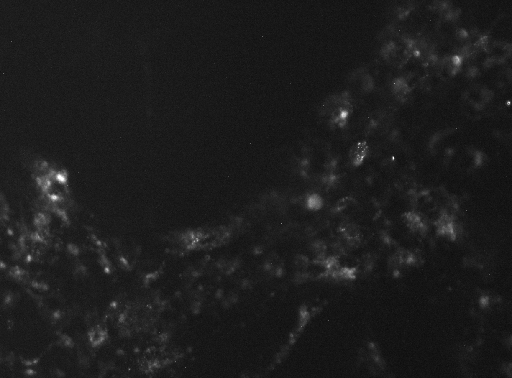

In [104]:
ecm_image[138]

Frame([[26352., 25808., 27376., ..., 24448., 24384., 24896.],
       [23072., 25888., 26304., ..., 22768., 24576., 23808.],
       [24384., 26528., 25360., ..., 23296., 24048., 23328.],
       ...,
       [30352., 29376., 29504., ..., 24736., 26928., 25872.],
       [29712., 29504., 30576., ..., 26000., 26720., 26864.],
       [30480., 29696., 31600., ..., 25600., 27200., 26224.]])
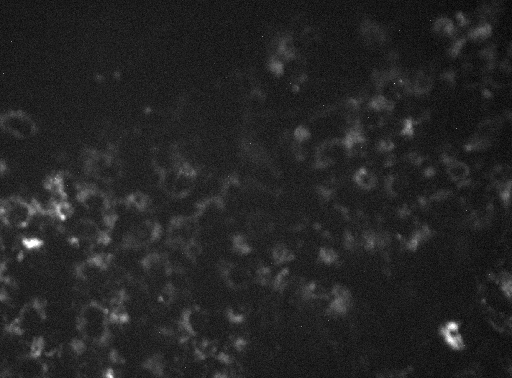

In [94]:
rfp[2]